# Test weighting the samples by group size
We simulate below some of the steps in the GAN training script... But first, let's load up some data.

In [5]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.patches import Ellipse
from genff.visualization.plotting import plot_sample, plot_sample_on_full_map
from genff.data_handling.dataset import GroupDataset
from genff.data_handling.utils import create_weighted_sampler, identify_group_sizes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dataset = GroupDataset("../data/cocktail_party/train_skip3.h5")
print("Loaded {} samples".format(len(dataset)))

Loading ../data/cocktail_party/train_skip3.h5
Loaded 468 samples


In [3]:
# split data into train/val
idx = torch.randperm(len(dataset))
split_idx = int(0.9*len(dataset))
train_idx = idx[:split_idx]
train_dataset = torch.utils.data.Subset(dataset, train_idx)
train_dataset.env_dict = dataset.env_dict

## A typical sampler
Let's try first a typical sampler and see what distribution we get...

Group sizes: [1, 2, 3, 4, 5]
Counts: [1, 1, 4, 4, 20]


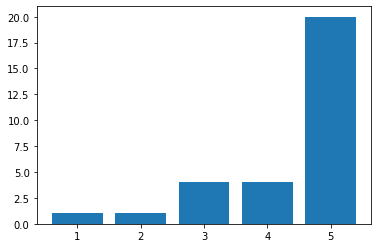

Counts: [0, 4, 7, 2, 17]


Counts: [1, 7, 3, 5, 14]


In [21]:
batch_size = 30
train_loader = torch.utils.data.DataLoader(train_dataset, num_workers=1, batch_size=batch_size)
group_sizes = identify_group_sizes(train_dataset)
print("Group sizes: {}".format(group_sizes))

def compute_group_size_count(batch):
    """
    Helper function to compute the prob of a group size (and the number of samples per group size)
    :param batch: dataset batch
    :param group_sizes: list with the group sizes (as output by identify_group_sizes())
    :return tuple with list of prob and counts per group size
    """
    num = [0 for _ in range(len(group_sizes))]
    mask = batch[2]
    for i in range(mask.shape[0]):
        m = mask[i]
        s = int(m.sum().item()) # size is given by the number of people in the context
        c = group_sizes.index(s)  # should never through ValueError exception
        num[c] += 1  # increase count for given class
    return num

def plot_distribution(batch_data):
    counts = compute_group_size_count(batch)
    print("Counts: {}".format(counts))
    plt.bar(group_sizes, counts)
    plt.show()
    
data_iter = iter(train_loader)
for i in range(3):
    batch = next(data_iter)
    plot_distribution(batch)

Counts: [6, 6, 6, 3, 9]


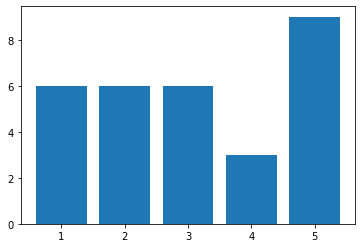

Counts: [6, 10, 5, 5, 4]


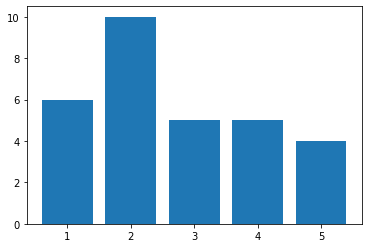

Counts: [5, 12, 5, 2, 6]


0.24873566627502441


In [30]:
# sample...
sampler = create_weighted_sampler(train_dataset)
train_loader_w = torch.utils.data.DataLoader(train_dataset, num_workers=0, batch_size = batch_size, 
                                             shuffle=False, sampler=sampler)

data_iter = iter(train_loader_w)
for i in range(3):
    batch = next(data_iter)
    plot_distribution(batch)